In [1]:
#
# Practical 2 - Text Classification
#

In [2]:
PROJECT_PATH = ".."

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

from tqdm import tqdm
from pprint import pprint
from time import time

from lib.data import (
    batch_pad_truncate_dataset,
    load_TED_dataset,
    drop_data_of_label,
)
from lib.text import (
    build_encoder_decoder_from_vocab,
    flat_clip_in_words,
)
from lib.plot import plot_frequency_map
from lib.model import train_evaluate_model

In [4]:
#
# Load Dataset
#

content_text, keywords_text = load_TED_dataset(
    include_keywords=True, project_path=PROJECT_PATH
)


def keywords_to_labels(keywords):
    label_keywords = ["technology", "entertainment", "design"]
    label_codes = [
        label_keyword.upper()[0] if label_keyword in keywords.lower() else "o"
        for label_keyword in label_keywords
    ]
    return "".join(label_codes)


flattened_content = [flat_clip_in_words(clip) for clip in tqdm(content_text)]
labels = list(map(keywords_to_labels, keywords_text))

dataset = list(zip(flattened_content, labels))

del content_text, keywords_text, flattened_content, labels

ted_en-20160408.zip already downloaded.


100%|██████████| 2085/2085 [00:08<00:00, 253.72it/s]


In [5]:
# %%
# Build Encoder
#
vocab = set([word for (clip, label) in dataset for word in clip])
encoder, _ = build_encoder_decoder_from_vocab(vocab)
print(len(vocab))
print(len(encoder))
print(encoder['_BOS_'])

54028
54033
54029


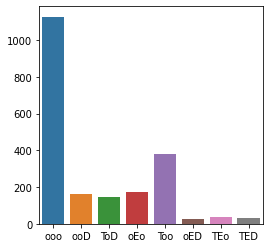

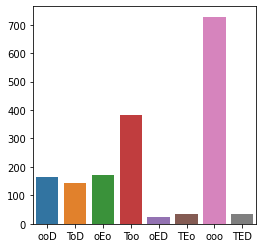

In [7]:
# 
# Optinoal: actively drop out samples with certain labels in the dataset 
# to check if balanced label distribution help improve model performance
#
plot_frequency_map([label for (content, label) in dataset])

balanced_dataset = drop_data_of_label(dataset, "ooo", 400)

plot_frequency_map([label for (content, label) in balanced_dataset])

In [8]:
#
# Encode Dataset
#

label_encoder = {
    "TEo": 0,
    "oEo": 1,
    "Too": 2,
    "oED": 3,
    "ToD": 4,
    "ooD": 5,
    "ooo": 6,
    "TED": 7,
}


def encode_dataset(dataset, encoder, label_encoder):
    output = [
        ([encoder[word] for word in clip], label_encoder[label])
        for (clip, label) in tqdm(dataset)
    ]
    return output


def pad_to_longest_clip(encoded_dataset):
    # pad each clip to the same length as longest clip
    longest_clip = max([len([word for word in clip]) for (clip, _) in encoded_dataset])

    output = [
        (
            np.append(encoded_clip, np.zeros(longest_clip - len(encoded_clip), dtype=int),),
            encoded_label,
        )
        for (encoded_clip, encoded_label) in tqdm(encoded_dataset)
    ]

    return output


encoded_dataset = pad_to_longest_clip(
    encode_dataset(balanced_dataset, encoder, label_encoder)
)

print(np.array(encoded_dataset).shape)
print(encoded_dataset[0])

100%|██████████| 1685/1685 [00:00<00:00, 3116.52it/s]

(1685, 2)
(array([54031, 54029, 27173, ...,     0,     0,     0]), 5)


In [9]:
# 
# Hyper-Parameters
#

ENCODER_SIZE = len(encoder)
EMBEDDING_SIZE = 100

In [11]:
#
# Optional: in case to use pre-trained embedding as initial weights
#

# %%
# train local word embeddings
from gensim.models import Word2Vec

print("W2V model training started...")
start = time()
TED_W2V = Word2Vec(
    sentences=[clip for (clip, _) in dataset], # use flattened_content clip as training data
    min_count=1,
    #     negative=10,
    size=EMBEDDING_SIZE,
).wv
print("W2V model training completed.")
print(time() - start)

W2V model training started...
W2V model training completed.
32.7603120803833


In [12]:
print(len(TED_W2V.vocab))

54032


In [14]:
def align_w2v_embedding_with_encoder(encoder, W2V_EMBEDDING):
    embedding = np.zeros([ENCODER_SIZE, EMBEDDING_SIZE])
    for word in tqdm(W2V_EMBEDDING.vocab):
        embedding[encoder[word]] = W2V_EMBEDDING[word]
    return embedding


TED_pretrained_W2V_embeddings = align_w2v_embedding_with_encoder(encoder, TED_W2V)

100%|██████████| 54032/54032 [00:00<00:00, 111278.37it/s]


test set shape: (168, 7331)
Train on 1349 samples, validate on 168 samples
Epoch 1/10
1349/1349 [==============================] - 5s 4ms/sample - loss: 1.9525 - accuracy: 0.4188 - val_loss: 1.8020 - val_accuracy: 0.4226
Epoch 2/10
1349/1349 [==============================] - 5s 4ms/sample - loss: 1.6932 - accuracy: 0.4418 - val_loss: 1.6381 - val_accuracy: 0.4226
Epoch 3/10
1349/1349 [==============================] - 5s 3ms/sample - loss: 1.6077 - accuracy: 0.4418 - val_loss: 1.6115 - val_accuracy: 0.4226
Epoch 4/10
1349/1349 [==============================] - 4s 3ms/sample - loss: 1.5886 - accuracy: 0.4418 - val_loss: 1.6029 - val_accuracy: 0.4226
Epoch 5/10
1349/1349 [==============================] - 5s 3ms/sample - loss: 1.5884 - accuracy: 0.4418 - val_loss: 1.6047 - val_accuracy: 0.4226
Epoch 6/10
1349/1349 [==============================] - 4s 3ms/sample - loss: 1.5792 - accuracy: 0.4418 - val_loss: 1.5971 - val_accuracy: 0.4226
Epoch 7/10
1349/1349 [===========================

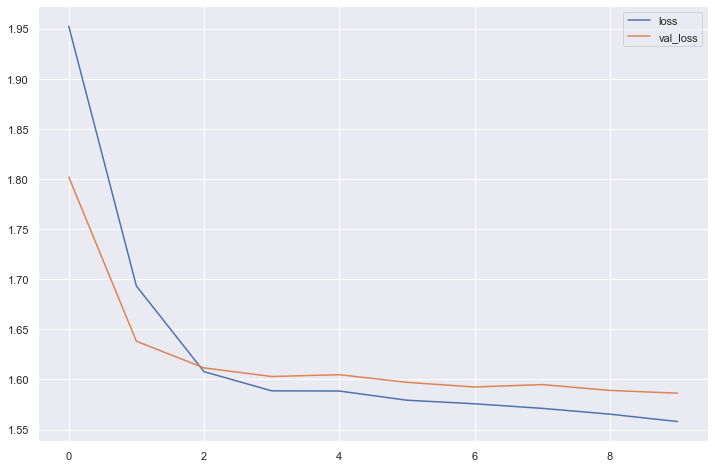

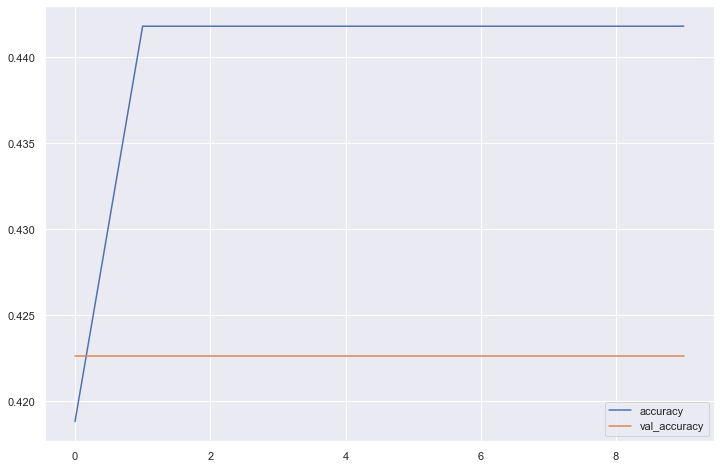

In [16]:
# Model - simple MLP classifier
#
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential(
    [
        layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE),
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="tanh", name="hidden_layer"),
        layers.Dense(8, activation="softmax", name="output"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (168, 7331)
Train on 1349 samples, validate on 168 samples
Epoch 1/10
1349/1349 [==============================] - 3s 2ms/sample - loss: 1.8020 - accuracy: 0.3973 - val_loss: 1.6316 - val_accuracy: 0.4345
Epoch 2/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.6279 - accuracy: 0.4307 - val_loss: 1.5907 - val_accuracy: 0.4345
Epoch 3/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5973 - accuracy: 0.4307 - val_loss: 1.5539 - val_accuracy: 0.4345
Epoch 4/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5768 - accuracy: 0.4307 - val_loss: 1.5356 - val_accuracy: 0.4345
Epoch 5/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5610 - accuracy: 0.4322 - val_loss: 1.5209 - val_accuracy: 0.4345
Epoch 6/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5448 - accuracy: 0.4374 - val_loss: 1.5104 - val_accuracy: 0.4345
Epoch 7/10
1349/1349 [===========================

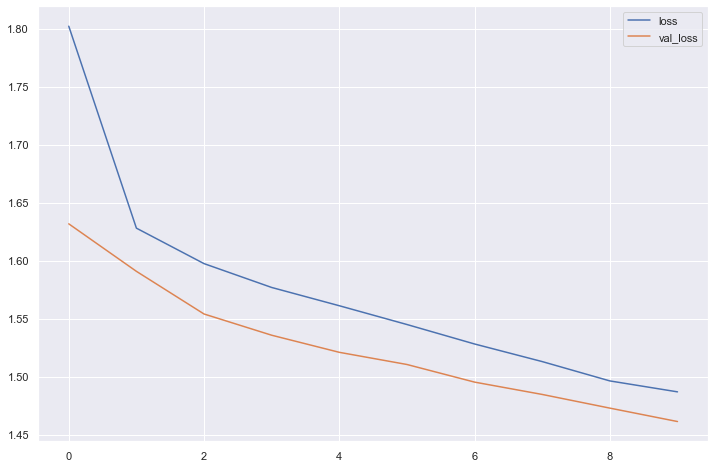

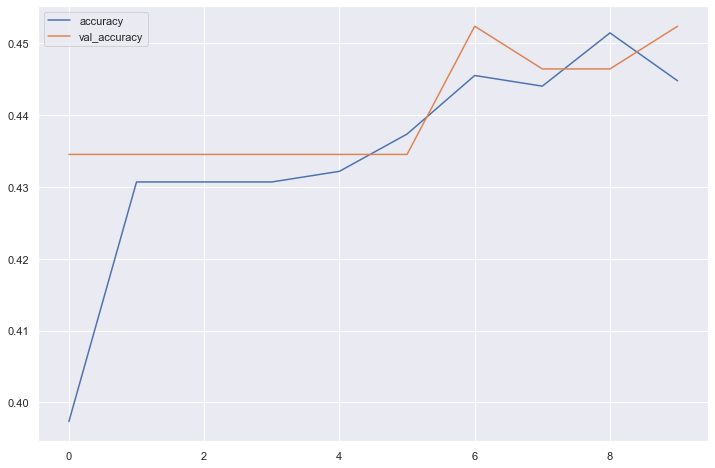

In [18]:
# Model - simple MLP classifier with frozen embedding pretrained by W2V
#
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()

embedding_layer = layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE)
embedding_layer.trainable = False
embedding_layer.build((None, ENCODER_SIZE))
embedding_layer.set_weights([TED_pretrained_W2V_embeddings])

model = tf.keras.models.Sequential(
    [
        embedding_layer,
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="tanh", name="hidden_layer"),
        layers.Dense(8, activation="softmax", name="output"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

test set shape: (168, 7331)
Train on 1349 samples, validate on 168 samples
Epoch 1/10
1349/1349 [==============================] - 2s 2ms/sample - loss: 1.7706 - accuracy: 0.4344 - val_loss: 1.6424 - val_accuracy: 0.4345
Epoch 2/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.6336 - accuracy: 0.4381 - val_loss: 1.5642 - val_accuracy: 0.4345
Epoch 3/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5967 - accuracy: 0.4381 - val_loss: 1.5468 - val_accuracy: 0.4345
Epoch 4/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5725 - accuracy: 0.4388 - val_loss: 1.5221 - val_accuracy: 0.4345
Epoch 5/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5514 - accuracy: 0.4381 - val_loss: 1.4997 - val_accuracy: 0.4345
Epoch 6/10
1349/1349 [==============================] - 2s 1ms/sample - loss: 1.5326 - accuracy: 0.4485 - val_loss: 1.4890 - val_accuracy: 0.4405
Epoch 7/10
1349/1349 [===========================

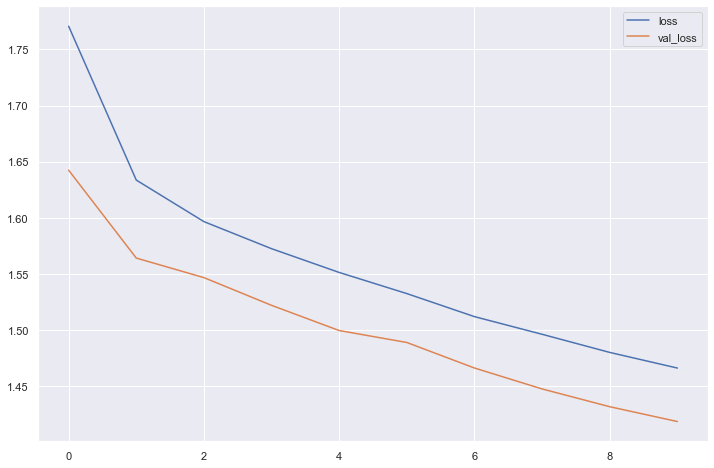

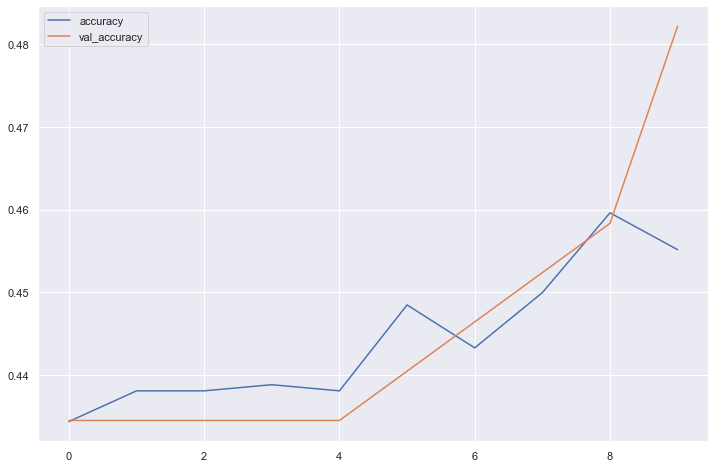

In [19]:
# Model - simple MLP classifier with trainable embedding pretrained by W2V
#
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()

embedding_layer = layers.Embedding(ENCODER_SIZE, EMBEDDING_SIZE)
embedding_layer.trainable = False
embedding_layer.build((None, ENCODER_SIZE))
embedding_layer.set_weights([TED_pretrained_W2V_embeddings])

model = tf.keras.models.Sequential(
    [
        embedding_layer,
        layers.GlobalAveragePooling1D(),
        layers.Dense(128, activation="tanh", name="hidden_layer"),
        layers.Dense(8, activation="softmax", name="output"),
    ]
)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"],
)

train_evaluate_model(model, encoded_dataset, visualise_metrics=['accuracy'])

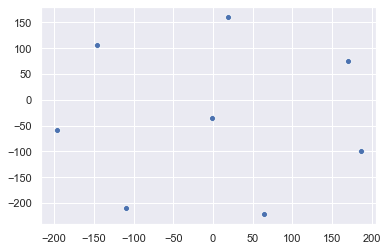

In [25]:
import seaborn as sns
from sklearn.manifold import TSNE

output_layer_weights = np.array(model.layers[-1].get_weights()[0]).T
weights_TSNE = TSNE(n_components=2, random_state=0).fit_transform(output_layer_weights)
sns.scatterplot(x=weights_TSNE[:, 0], y=weights_TSNE[:, 1], legend="full")

In [ ]:
#
# answer to questions
#
# 1. Using pre-trained embeddings based on contextual co-occurence, such as
# local Word2Vec or GloVe, has the effect of an obviously lower initial loss and accurarcy,
# while it doesn't contribute significantly to the final accuracy.
# Task based embedding with random initialisation will quickly decent to similar loss during training
# after 2-3 epochs.
#
# 2. Change of non-linear function for activation affects the accuracy of the model,
# but not hugely, while tanh has worked best in this situation.
# Removing the tanh non-linear layer doesn't affect the accuracy significantly actually, while
# the loss decent in a more linear way.
#
# 3. Adding dropout can slightly help to generalise the model and improve the test accuracy of the model.
#
# 4. Increasing the units in the hidden layer deosn't necessary improve test accurarcy.
#
# 5. Adding another hidden layer is simple, but doesn't necessary improve test accuracy significantly.
#
# 6. Currently, sparse_categorical_crossentropy and adam optimiser are used.
#
# 7. The distribution forms an oval shape, with 'ooo' as the centre, and then 'Too', 'Eoo', 'ooD' as the separation point, which shows expected levels of correlation between classes of similar labels.
#
# 8. Multi-label classifier:
#   1. update the label encoder to output array of label status
#   2. update output layer activation to sigmoid instead of softmax
#   3. update training loss function to binary-corss-entropy
#   4. evaluation metrics - accuracy is equal to micro-f1
#   5. testing the effect of adding a crf(conditional random field)?
#     currently the distribution of the output label weights on labels is like a triangle
